In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from datetime import date, datetime

In [3]:
raw_train = pd.read_csv('datasets/train_classification.csv')
raw_test = pd.read_csv('datasets/test_classification.csv')

In [4]:
train = raw_train.copy()
test = raw_test.copy()


train['acceptance_rate'] = train['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
train['response_rate'] = train['host_response_rate'].str.replace('%', '').astype(float) / 100

test['acceptance_rate'] = test['host_acceptance_rate'].str.replace('%', '').astype(float) / 100
test['response_rate'] = test['host_response_rate'].str.replace('%', '').astype(float) / 100


In [5]:
response_time_dict = {'within an hour': 1, 'within a few hours': 12, 'within a day': 24, 'a few days or more': 72}

def replace_response_time(row):
    if pd.notna(row):
        return response_time_dict.get(row)
    else:
        return None

train['response_time'] = train['host_response_time'].apply(replace_response_time)
test['response_time'] = test['host_response_time'].apply(replace_response_time)


train['response_time'].value_counts()

1.0     3846
12.0     433
24.0     230
72.0      51
Name: response_time, dtype: int64

In [6]:
train.drop(columns=['host_acceptance_rate', 'host_response_rate'], inplace=True)
test.drop(columns=['host_acceptance_rate', 'host_response_rate'], inplace=True)

In [7]:
# Convert date columns
def strip_date(row):
    if isinstance(row, str):
        row = datetime.strptime(row, '%Y-%m-%d').date()
    return row

# Apply date conversion to train dataset
train['host_since'] = train['host_since'].apply(strip_date)
train['first_review'] = train['first_review'].apply(strip_date)
train['last_review'] = train['last_review'].apply(strip_date)

# Apply date conversion to test dataset
test['host_since'] = test['host_since'].apply(strip_date)
test['first_review'] = test['first_review'].apply(strip_date)
test['last_review'] = test['last_review'].apply(strip_date)


# Create columns for individual aspects of date 
train['host_since_year'] = train['host_since'].apply(lambda x: x.year if pd.notnull(x) else None)
train['host_since_month'] = train['host_since'].apply(lambda x: x.month if pd.notnull(x) else None)
train['host_since_day'] = train['host_since'].apply(lambda x: x.day if pd.notnull(x) else None)

train['first_review_year'] = train['first_review'].apply(lambda x: x.year if pd.notnull(x) else None)
train['first_review_month'] = train['first_review'].apply(lambda x: x.month if pd.notnull(x) else None)
train['first_review_day'] = train['first_review'].apply(lambda x: x.day if pd.notnull(x) else None)

train['last_review_year'] = train['last_review'].apply(lambda x: x.year if pd.notnull(x) else None)
train['last_review_month'] = train['last_review'].apply(lambda x: x.month if pd.notnull(x) else None)
train['last_review_day'] = train['last_review'].apply(lambda x: x.day if pd.notnull(x) else None)


test['host_since_year'] = test['host_since'].apply(lambda x: x.year if pd.notnull(x) else None)
test['host_since_month'] = test['host_since'].apply(lambda x: x.month if pd.notnull(x) else None)
test['host_since_day'] = test['host_since'].apply(lambda x: x.day if pd.notnull(x) else None)

test['first_review_year'] = test['first_review'].apply(lambda x: x.year if pd.notnull(x) else None)
test['first_review_month'] = test['first_review'].apply(lambda x: x.month if pd.notnull(x) else None)
test['first_review_day'] = test['first_review'].apply(lambda x: x.day if pd.notnull(x) else None)

test['last_review_year'] = test['last_review'].apply(lambda x: x.year if pd.notnull(x) else None)
test['last_review_month'] = test['last_review'].apply(lambda x: x.month if pd.notnull(x) else None)
test['last_review_day'] = test['last_review'].apply(lambda x: x.day if pd.notnull(x) else None)


# Calculate months since various dates for train dataset
train['host_since_in_months'] = round(((datetime.now().date() - train['host_since']).dt.days) / 30, 2)
train['first_review_in_months'] = round(((datetime.now().date() - train['first_review']).dt.days) / 30, 2)
train['last_review_in_months'] = round(((datetime.now().date() - train['last_review']).dt.days) / 30, 2)

# Calculate months since various dates for test dataset
test['host_since_in_months'] = round(((datetime.now().date() - test['host_since']).dt.days) / 30,  2)
test['first_review_in_months'] = round(((datetime.now().date() - test['first_review']).dt.days) / 30, 2)
test['last_review_in_months'] = round(((datetime.now().date() - test['last_review']).dt.days) / 30, 2)


In [8]:
t_f_vars = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
t_f_vars_test = ['host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']


train[t_f_vars] = train[t_f_vars].replace({'f': 0, 't': 1})
test[t_f_vars_test] = test[t_f_vars_test].replace({'f': 0, 't': 1})


In [9]:
train_clean = train.copy() 
test_clean = test.copy() 

### Clean/Transform Variables

In [10]:

neighbourhood_counts = train_clean['neighbourhood_cleansed'].value_counts()  
    
def clean_rooms(row):    
    if row.loc['room_type'] == 'Hotel room':
        row['room_type'] = 'Private room'
        
    if row.loc['room_type'] == 'Shared room':
        row['room_type'] = 'Entire home/apt'
        
    return row


 
test_only_hoods = [i for i in test_clean['neighbourhood_cleansed'].unique() 
                   if i not in neighbourhood_counts 
                   and i != 'Other']
    
    

In [11]:
train_clean['host_verifications_list'] = train_clean['host_verifications'].apply(lambda x: x.strip("[]").replace("'", "").split(', '))
test_clean['host_verifications_list'] = test_clean['host_verifications'].apply(lambda x: x.strip("[]").replace("'", "").split(', '))

train_clean['num_verifications']  = train_clean['host_verifications_list'].apply(len)
test_clean['num_verifications']  = test_clean['host_verifications_list'].apply(len)


In [12]:
train_clean['phone_verification']  = train_clean['host_verifications_list'].apply(lambda x: 1 if 'phone' in x else 0)
train_clean['email_verification']  = train_clean['host_verifications_list'].apply(lambda x: 1 if 'email' in x else 0)
train_clean['work_email_verification'] = train_clean['host_verifications_list'].apply(lambda x: 1 if 'work_email' in x else 0)
train_clean['any_email_verification'] = train_clean['host_verifications_list'].apply(lambda x: 1 if 'work_email' in x or 'email' in x else 0)
# print(train_clean['num_verifications'].value_counts(), '\n')

test_clean['phone_verification']  = test_clean['host_verifications_list'].apply(lambda x: 1 if 'phone' in x else 0)
test_clean['email_verification']  = test_clean['host_verifications_list'].apply(lambda x: 1 if 'email' in x else 0)
test_clean['work_email_verification'] = test_clean['host_verifications_list'].apply(lambda x: 1 if 'work_email' in x else 0)
test_clean['any_email_verification'] = test_clean['host_verifications_list'].apply(lambda x: 1 if 'work_email' in x or 'email' in x else 0)
# print(train_clean['num_verifications'].value_counts(), '\n')


In [13]:
bins = [0, 14, 30, 60, 90, 180, 365, float('inf')]
labels = ['0-14', '14-30', '30-60', '60-90', '90-180', '180-365', '365<']

train_clean['max_nights_cats'], max_bins = pd.cut(train_clean.maximum_nights, bins=bins, labels=labels, retbins=True, right=False, include_lowest=True)
test_clean['max_nights_cats'] = pd.cut(test_clean.maximum_nights, bins=max_bins, labels=labels, right=False, include_lowest=True)


In [14]:
# for host listing count outliers (>80) set to median
def clean_host_listing(row):
    if row > 80:
        row = None
    return row


train_clean['calculated_host_listings_count'] = train_clean['calculated_host_listings_count'].apply(clean_host_listing)
test_clean['calculated_host_listings_count'] = test_clean['calculated_host_listings_count'].apply(clean_host_listing)

train_clean['calculated_host_listings_count'].fillna(train_clean['calculated_host_listings_count'].median())
test_clean['calculated_host_listings_count'].fillna(test_clean['calculated_host_listings_count'].median())


0       44.0
1        3.0
2       51.0
3       14.0
4       19.0
        ... 
3319    22.0
3320    12.0
3321    12.0
3322     8.0
3323     2.0
Name: calculated_host_listings_count, Length: 3324, dtype: float64

In [15]:
train_clean['reviews_per_listing'] = train_clean['number_of_reviews']/train_clean['calculated_host_listings_count']
train_clean['reviews_per_month'] = train_clean['number_of_reviews']/train_clean['host_since_in_months']
train_clean['reviews_per_listing_per_month'] = train_clean['reviews_per_listing']/train_clean['host_since_in_months']

test_clean['reviews_per_listing'] = test_clean['number_of_reviews']/test_clean['calculated_host_listings_count']
test_clean['reviews_per_month'] = test_clean['number_of_reviews']/test_clean['host_since_in_months']
test_clean['reviews_per_listing_per_month'] = test_clean['reviews_per_listing']/test_clean['host_since_in_months']


#### Sophisticated Cleaning of Neighbourhoods

In [16]:
other_hoods = []
for i in neighbourhood_counts.index:
    if neighbourhood_counts[i] < 150:
        other_hoods.append(i)         
    
def clean_hoods(row):
    if row.loc['neighbourhood_cleansed'] in other_hoods or row.loc['neighbourhood_cleansed'] in test_only_hoods:
        row['neighbourhood_grouped'] = 'Other'
        
    else:    
        row['neighbourhood_grouped'] = row.loc['neighbourhood_cleansed']
        
    return row
       

In [17]:
train_clean = train_clean.apply(clean_hoods, axis=1)  

In [18]:
hood_df = pd.DataFrame()
hood_df.index = train_clean['neighbourhood_grouped'].unique()

In [19]:
avail_hoods = train_clean['neighbourhood_grouped'].unique()

def test_consistent_hoods(row):
    if row not in avail_hoods:
        row = 'Other'       
    return row

test_clean['neighbourhood_grouped'] = test_clean['neighbourhood_cleansed'].apply(test_consistent_hoods)
# test_clean['neighbourhood_grouped'].value_counts()


In [20]:
grab_vars = ['host_id', 'host_listings_count', 'host_total_listings_count']

train_filter_2 = train_clean.drop(columns=grab_vars)
test_filter_2 = test_clean.drop(columns=grab_vars)


In [21]:
temp_data_train = train_filter_2.dropna(how='any')

for col in temp_data_train.select_dtypes(include='number').columns:
    if train_filter_2.isna().sum()[col] != 0:
        train_filter_2[col].fillna(value=train_filter_2[col].median(), inplace=True) 

train_final = train_filter_2.copy()

value_counts = train_final.isna().sum()
value_counts[value_counts != 0]

review_vars = [name for name in train_final.columns if 'review' in name]
review_corrs = train_final[review_vars].corr()
# review_corrs[(review_corrs != 1.0) & (review_corrs > 0.7)]


C:\Users\emmal\AppData\Local\Temp\ipykernel_35000\162466571.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  review_corrs = train_final[review_vars].corr()


In [22]:
temp_data_test = test_filter_2.dropna(how='any')

for col in temp_data_test.select_dtypes(include='number').columns:
    if test_filter_2.isna().sum()[col] != 0:
        test_filter_2[col].fillna(value=test_filter_2[col].median(), inplace=True)  

test_final = test_filter_2.copy()


In [23]:
train_final['accommodates_bins'], bins = pd.cut(train_final['accommodates'], retbins=True, bins=6)
test_final['accommodates_bins'] = pd.cut(test['accommodates'], bins=bins)


In [24]:
train_final['latitude_bins'], lat_bins = pd.cut(train_final['latitude'], retbins=True, bins=12)
train_final['longitude_bins'], long_bins = pd.cut(train_final['longitude'], retbins=True, bins=12)

test_final['latitude_bins'] = pd.cut(test['accommodates'], bins=lat_bins)
test_final['longitude_bins'] = pd.cut(test['accommodates'], bins=long_bins)


In [25]:
train_final['accommodates_root'] = np.sqrt(train_final['accommodates'])
test_final['accommodates_root'] = np.sqrt(test_final['accommodates'])

## **Test Space**

In [26]:
# non_us = ['Italy', 'Tulum, Mexico', 'Toronto, Canada', 'United Kingdom', 'Cartagena, Colombia']
# non_us.append('United States')

# host_locals_count = train_final['host_location'].value_counts() #.drop(non_us)
# major_host_locals = host_locals_count[host_locals_count < 3]
# major_host_locals = list(major_host_locals.index)

# temp_host_data = train_final[~train_final['host_location'].isin(non_us)]
# # temp_host_data = temp_host_data[temp_host_data['host_location'] != 'Chicago, IL']

# print(temp_host_data['latitude'].max(), temp_host_data['latitude'].min(), temp_host_data['longitude'].max(), temp_host_data['longitude'].min())

# max_diff = max([temp_host_data['latitude'].max()-temp_host_data['latitude'].min(), temp_host_data['longitude'].min()-temp_host_data['longitude'].max()])
# print(max_diff)
# max_diff_half = max_diff/2






<Axes: xlabel='neighbourhood_grouped', ylabel='host_is_superhost'>

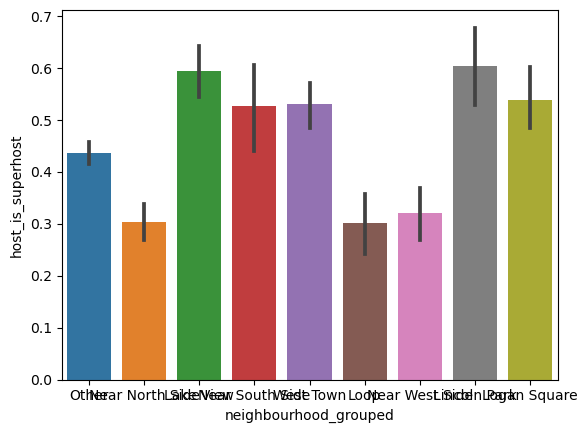

In [27]:
sns.barplot(data=train_final, x='neighbourhood_grouped', y='host_is_superhost')

### Function to evaluate model

In [28]:
def evaluate_model(train_final, formula, last_rmse, last_mae, best_rmse, best_mae, best_diff, best_rmse_formula, best_mae_formula):
    try:
        model = smf.ols(formula=formula, data=train_final).fit()
        trying_pred = model.predict(train_final)
        trying_pred = np.exp(trying_pred)
        rmse = mean_squared_error(train_final['price'], trying_pred, squared=False)
        mae = mean_absolute_error(train_final['price'], trying_pred)
        mae_rmse_diff = rmse - mae 

        difference_rmse = (rmse - last_rmse)
        difference_mae = (mae - last_mae)   

        if difference_rmse > 0:
            print(f'''RMSE: {round(rmse, 3)}\nMAE: {round(mae, 3)}\nDiff: {mae_rmse_diff}\n''')
            print(f"RMSE Increase by {difference_rmse}")

        elif difference_rmse < 0:
            print(f'''RMSE: {round(rmse, 3)}\nMAE: {round(mae, 3)}\nDiff: {mae_rmse_diff}\n''')
            print(f"RMSE Decreased: {difference_rmse}")
        else: 
            print(f'''\t- No change -\nRMSE: {round(rmse, 3)}\nMAE: {round(mae, 3)}\nDiff: {mae_rmse_diff}\n''')

        if rmse <= best_rmse:
            best_rmse = rmse
            best_rmse_formula = formula
            print(f"Best RMSE!")

        if mae <= best_mae:
            best_mae = mae
            best_mae_formula = formula
            print(f"Best MAE!")    

        if mae_rmse_diff <= best_diff:
            best_diff = mae_rmse_diff
            print(f"Best Diff!\t {best_diff}")

        print(f"\nlast rmse {last_rmse}; last mae {last_mae}")    
        if best_rmse != rmse:
            print(f"Best RMSE {best_rmse}; Best MAE {best_mae}")    

        last_rmse = rmse
        last_mae = mae    

    except Exception as e:
        print("An error occurred:", e)
    

In [29]:
train_clean.columns

Index(['id', 'host_id', 'host_since', 'host_location', 'host_response_time',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'beds', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_

In [42]:
formula= '''host_is_superhost ~ host_total_listings_count*number_of_reviews_ltm + 
number_of_reviews_ltm*response_rate + acceptance_rate*number_of_reviews_ltm +
review_scores_cleanliness + I(review_scores_cleanliness**3) + 
availability_90 + C(neighbourhood_grouped, Treatment('West Town')) + 
host_since_in_months*host_total_listings_count + response_time + review_scores_communication*review_scores_checkin + review_scores_rating'''

# host_since_months*number_of_reviews_ltm

model = smf.logit(formula=formula, data=train_clean).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.505834
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      host_is_superhost   No. Observations:                 3653
Model:                          Logit   Df Residuals:                     3627
Method:                           MLE   Df Model:                           25
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                  0.2667
Time:                        20:40:34   Log-Likelihood:                -1847.8
converged:                       True   LL-Null:                       -2519.8
Covariance Type:            nonrobust   LLR p-value:                3.449e-268
=======================================================================================================================================
                                                                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               0.9083      3.381      0.269      0.788      -5.718       7.535
C(neighbourhood_grouped, Treatment('West Town'))[T.Lake View]           0.4684      0.194      2.409      0.016       0.087       0.850
C(neighbourhood_grouped, Treatment('West Town'))[T.Lincoln Park]        0.5627      0.249      2.256      0.024       0.074       1.052
C(neighbourhood_grouped, Treatment('West Town'))[T.Logan Square]       -0.1606      0.207     -0.775      0.438      -0.567       0.245
C(neighbourhood_grouped, Treatment('West Town'))[T.Loop]                0.6177      0.270      2.285      0.022       0.088       1.148
C(neighbourhood_grouped, Treatment('West Town'))[T.Near North Side]     0.0256      0.178      0.144      0.886      -0.324       0.375
C(neighbourhood_grouped, Treatment('West Town'))[T.Near South Side]     1.3268      0.270      4.914      0.000       0.798       1.856
C(neighbourhood_grouped, Treatment('West Town'))[T.Near West Side]      0.2208      0.218      1.015      0.310      -0.206       0.647
C(neighbourhood_grouped, Treatment('West Town'))[T.Other]               0.0536      0.132      0.408      0.684      -0.204       0.312
host_total_listings_count                                              -0.0038      0.002     -2.304      0.021      -0.007      -0.001
number_of_reviews_ltm                                                  -0.0648      0.059     -1.100      0.271      -0.180       0.051
host_total_listings_count:number_of_reviews_ltm                        -0.0005   8.66e-05     -6.067      0.000      -0.001      -0.000
response_rate                                                          -0.2908      0.877     -0.332      0.740      -2.009       1.428
number_of_reviews_ltm:response_rate                                     0.2181      0.040      5.480      0.000       0.140       0.296
acceptance_rate                                                         1.7909      0.375      4.779      0.000       1.056       2.525
acceptance_rate:number_of_reviews_ltm                                  -0.1164      0.043     -2.690      0.007      -0.201      -0.032
review_scores_cleanliness                                              -1.7598      1.294     -1.360      0.174      -4.296       0.776
I(review_scores_cleanliness ** 3)                                       0.0533      0.021      2.494      0.013       0.011       0.095
availability_90                                                        -0.0013      0.001     -1.117      0.264      -0.004       0.001
host_since_in_months                                                    0.0057      0.001      5.329      0.000       0.004       0.008
host_since_in_months:host_total_listings_count                       3.023e-05   1.28e-05      2.366      0.018  

In [43]:
def get_acc(thresholds, model, df):
    y_pred_prob = np.array(model.predict(df))
    y_pred = y_pred_prob > thresholds[:, np.newaxis]
    y_true = df['host_is_superhost'].values
    y_true_reshaped = np.repeat(y_true[:, np.newaxis], len(y_true), axis=1)
    
    accuracies = []

    # Iterate over the rows of both arrays
    for row1, row2 in zip(y_true_reshaped, y_pred):
        acc = accuracy_score(row1, row2)
        accuracies.append(acc)
    
    max_acc_index = np.argmax(accuracies)
    max_acc = accuracies[max_acc_index]
    max_acc_threshold = thresholds[max_acc_index]
    
    return max_acc, max_acc_threshold, max_acc_index, accuracies





thresholds_a = np.linspace(0.4, 0.6, num=101)



from sklearn.model_selection import KFold 

folds = 5

df = train_clean.copy()


kf =KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices = []

cnt = 1
acc_dict = {}

for test, train_index in kf.split(train_clean):
    fold_indices.append(train_index)
    print(f'Fold: {cnt}, Train set: {len(train_index)}')
    
    temp_data = train_clean.iloc[train_index, :]
    max_acc, max_acc_threshold, max_acc_index, accuracy_matrix = get_acc(thresholds_a, model, temp_data)
    
    acc_dict[cnt] = accuracy_matrix
    
    cnt += 1


# print(acc_dict)

thresh_dict = {}
    
for thresh_idx, thresh in enumerate(acc_dict[1]):  # each of the thresholds
    thresh_dict[thresh_idx] = []
    
    for fold in range(1, len(acc_dict.keys())+1):
        curr_acc = acc_dict[fold][thresh_idx]
    
        thresh_dict[thresh_idx].append(curr_acc)




mean_accs = []
for key in thresh_dict.keys():
    mean_accs.append(np.mean(thresh_dict[key]))


print(max(mean_accs), np.argmax(mean_accs))


max_acc_a, max_acc_threshold_a, max_acc_idx_a = max(mean_accs), thresholds_a[np.argmax(mean_accs)], np.argmax(mean_accs)
max_acc_a, max_acc_threshold_a, max_acc_idx_a


Fold: 1, Train set: 996
Fold: 2, Train set: 996
Fold: 3, Train set: 995
Fold: 4, Train set: 995
Fold: 5, Train set: 995
0.5708114871546487 96


(0.5708114871546487, 0.592, 96)

In [44]:
thresholds_b = np.linspace(thresholds_a[max_acc_idx_a-1], thresholds_a[max_acc_idx_a+1], num=101)
print(thresholds_a[max_acc_idx_a-1], thresholds_a[max_acc_idx_a+1])


from sklearn.model_selection import KFold 

folds = 5

df = train_clean.copy()
print(len(df))
print(len(df)/5)



kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_indices_b = []

cnt = 1
acc_dict_b = {}

for test, train_index in kf.split(train_clean):
    fold_indices_b.append(train_index)
    print(f'Fold: {cnt}, Train set: {len(train_index)}')
    
    temp_data = train_clean.iloc[train_index, :]
    max_acc, max_acc_threshold, max_acc_index, accuracy_matrix = get_acc(thresholds_b, model, temp_data)
    
    acc_dict_b[cnt] = accuracy_matrix
    
    cnt += 1



thresh_dict_b = {}
    
for thresh_idx, thresh in enumerate(acc_dict_b[1]):  # each of the thresholds
    thresh_dict_b[thresh_idx] = []
    
    for fold in range(1, len(acc_dict.keys())+1):
        curr_acc = acc_dict_b[fold][thresh_idx]
    
        thresh_dict_b[thresh_idx].append(curr_acc)




mean_accs_b = []
for key in thresh_dict_b.keys():
    mean_accs_b.append(np.mean(thresh_dict_b[key]))


print(max(mean_accs_b), np.argmax(mean_accs_b))


optimal_threshold = thresholds_b[np.argmax(mean_accs_b)]
optimal_threshold

# max_acc_a, max_acc_threshold_a, max_acc_idx_a, _ = get_acc(thresholds_a, model, train_clean)

# max_acc_a, max_acc_threshold_a, max_acc_idx_a

0.59 0.594
4977
995.4
Fold: 1, Train set: 996
Fold: 2, Train set: 996
Fold: 3, Train set: 995
Fold: 4, Train set: 995
Fold: 5, Train set: 995
0.6124195273556537 45


0.5918

In [33]:
# print(f'Optimal Threshold: {max_acc_threshold_b}\tIndex: {max_acc_idx_a}')

NameError: name 'max_acc_threshold_b' is not defined

In [45]:
# optimal_threshold = max_acc_threshold_b
print(optimal_threshold)

y_pred = model.predict(train_clean) > optimal_threshold
acc_score = accuracy_score(train_clean.host_is_superhost, y_pred)*100
precision = precision_score(train_clean.host_is_superhost, y_pred)*100
recall = recall_score(train_clean.host_is_superhost, y_pred)*100


print(y_pred.value_counts())
print(acc_score)
print(precision, recall)

confusion_matrix(train_clean.host_is_superhost, y_pred)

0.5918
False    3048
True     1929
dtype: int64
76.71287924452481
76.56817003628824 67.62820512820514


array([[2341,  452],
       [ 707, 1477]], dtype=int64)

In [523]:
# best_score = 75.9493670886076

In [46]:
acc_score = accuracy_score(train_clean.host_is_superhost, y_pred)*100
precision = precision_score(train_clean.host_is_superhost, y_pred)*100
recall = recall_score(train_clean.host_is_superhost, y_pred)*100


try:
    difference = (acc_score-last_acc_score)
        
    if difference > 0:
        print(acc_score)
        print(f"Improved by {difference}")
        print(f"(last acc_score {last_acc_score})")
            
    elif difference < 0:
        print(acc_score)
        print(f"Decreased: {difference}")
        print(f"(last acc_score {last_acc_score})") 

    else: 
        print(acc_score, "(No change)")
        
except:
    print(acc_score)


try:
    if acc_score >= best_score:
        best_score = acc_score
        best_formula = formula

        print("\nBest Score!\n")
except:
    pass

    
# try:    
#     print(f"\nBest Score: {best_score}\tLast Score: {last_score}")    
# except:
#     print(f"\nBest Score: {best_score}")

    
print(f"Precision: {precision}\tRecall: {recall}")
    
last_acc_score = acc_score 

76.71287924452481
Improved by 0.32147880249145544
(last acc_score 76.39140044203336)
Precision: 76.56817003628824	Recall: 67.62820512820514


In [47]:
test_pred = (model.predict(test_clean) > optimal_threshold).replace({False:0, True:1})

overlapping_hosts = train_clean[train_clean['host_id'].isin(test_clean['host_id'])].drop_duplicates('host_id')[['host_id', 'host_is_superhost']]

predicted_values = pd.concat([test_clean[['id', 'host_id']], test_pred.rename('predicted')], axis=1)


def overwrite(row):
    if row['host_id'] in overlapping_hosts['host_id'].values:
        row['predicted'] = overlapping_hosts[overlapping_hosts['host_id'] == row['host_id']]['host_is_superhost'].values[0]
    return row
        
          
predicted_values = predicted_values.apply(overwrite, axis=1)
predicted_values = predicted_values[['id', 'predicted']].set_index('id')

# predicted_values.to_csv('classification_model_take_9.csv') 